In [1]:
import pandas as pd

In [2]:
from sagemaker import get_execution_role
role=get_execution_role()
bucket='sagemaker-first1' #use the name of your bucket here

In [3]:
role

'arn:aws:iam::338414223723:role/service-role/AmazonSageMaker-ExecutionRole-20200526T224497'

In [4]:

%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 855 ms, sys: 331 ms, total: 1.19 s
Wall time: 2.37 s


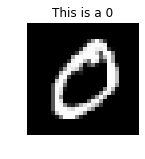

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot == None:
        _, (subplot) = plt.subplots(1,1)
    imgr = img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][1], 'This is a {}'.format(train_set[1][1]))

In [11]:

from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_highlevel_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location,
                k=10,
                epochs=100,
                data_location=data_location)

training data will be uploaded to: s3://sagemaker-first1/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://sagemaker-first1/kmeans_highlevel_example/output


In [12]:
%%time

kmeans.fit(kmeans.record_set(train_set[0]))

2020-05-27 02:56:51 Starting - Starting the training job...
2020-05-27 02:56:53 Starting - Launching requested ML instances......
2020-05-27 02:57:55 Starting - Preparing the instances for training...
2020-05-27 02:58:47 Downloading - Downloading input data...
2020-05-27 02:59:19 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/27/2020 02:59:37 INFO 140049757583168] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval


2020-05-27 02:59:33 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/27/2020 02:59:36 INFO 140108046878528] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[05/27/2020 02:59:36 INFO 140108046878528] Reading provided configuration from /opt/ml/input/config/hyperp

[2020-05-27 02:59:48.824] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 187, "duration": 103, "num_examples": 5, "num_bytes": 79100000}
[05/27/2020 02:59:48 INFO 140049757583168] processed a total of 25000 examples
[05/27/2020 02:59:48 INFO 140049757583168] #progress_metric: host=algo-1, completed 94 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 5, "sum": 5.0, "min": 5}, "Number of Batches Since Last Reset": {"count": 1, "max": 5, "sum": 5.0, "min": 5}, "Number of Records Since Last Reset": {"count": 1, "max": 25000, "sum": 25000.0, "min": 25000}, "Total Batches Seen": {"count": 1, "max": 471, "sum": 471.0, "min": 471}, "Total Records Seen": {"count": 1, "max": 2355000, "sum": 2355000.0, "min": 2355000}, "Max Records Seen Between Resets": {"count": 1, "max": 25000, "sum": 25000.0, "min": 25000}, "Reset Count": {"count": 1, "max": 94, "sum": 94.0, "min": 94}}, "EndTime": 1590548388.824653, "Dimensions": {"


2020-05-27 03:00:02 Uploading - Uploading generated training model
2020-05-27 03:00:02 Completed - Training job completed
Training seconds: 150
Billable seconds: 150
CPU times: user 8.54 s, sys: 437 ms, total: 8.98 s
Wall time: 3min 52s


In [13]:
%%time
#deploy the model to make predictions

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

---------------!CPU times: user 255 ms, sys: 25.8 ms, total: 280 ms
Wall time: 7min 32s


In [14]:
%%time 

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 34.6 ms, sys: 498 µs, total: 35.1 ms
Wall time: 250 ms





Cluster 0:


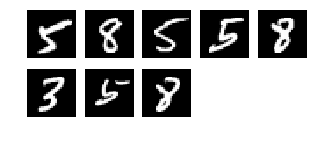




Cluster 1:


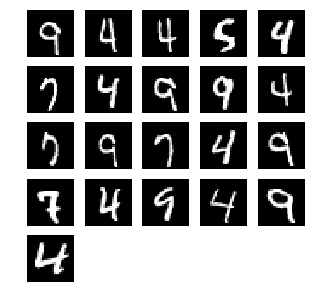




Cluster 2:


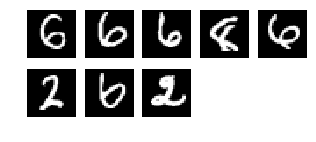




Cluster 3:


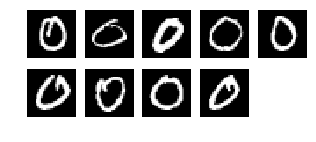




Cluster 4:


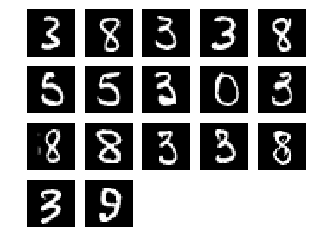




Cluster 5:


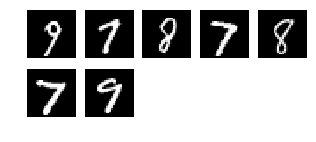




Cluster 6:


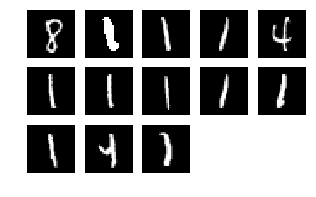




Cluster 7:


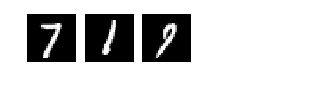




Cluster 8:


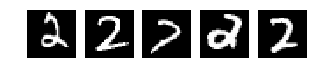




Cluster 9:


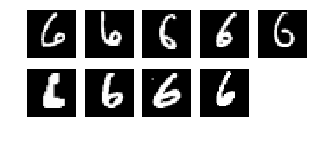

In [15]:

for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height = ((len(digits)-1)//5) + 1
    width = 5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots = numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

In [21]:
result = kmeans_predictor.predict(valid_set[0][235:236])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 9.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 6.5558271408081055
    }
  }
}
]


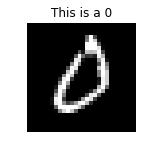

In [22]:
show_digit(valid_set[0][235], 'This is a {}'.format(valid_set[1][235]))
